# Create a transit lightcurve

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
from squishyplanet import OblateSystem

First, let's create a generic-looking spherical hot Jupiter.

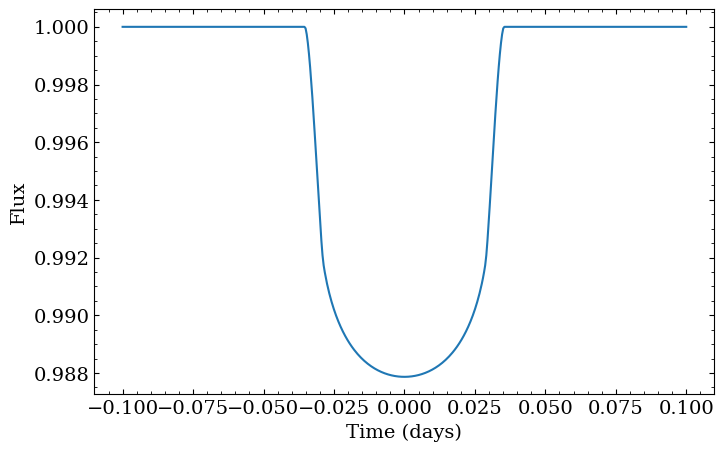

In [2]:
state = {
    "t_peri" : -0.25,
    "times" : jnp.linspace(-0.1, 0.1, 500),
    "a" : 5.0,
    "period" : 1.0,
    "r" : 0.1,
    "i" : jnp.pi/2,
    "ld_u_coeffs":jnp.array([0.4, 0.26]),
    "tidally_locked" : False,
}

spherical_planet = OblateSystem(**state)
spherical_lc = spherical_planet.lightcurve()

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(spherical_planet.state["times"], spherical_lc)
ax.set(xlabel="Time (days)", ylabel="Flux");

That curve doesn't correct for the blurring we get from finite exposure times. We can correct for that by creating a new `OblateSystem` that oversamples the lightcurve by some user-supplied factor, then integrates the oversampled curve over the exposure time. The interface for this closely follows the `starry` implementation of the same idea, and we use a nearly identical implementation under-the-hood.

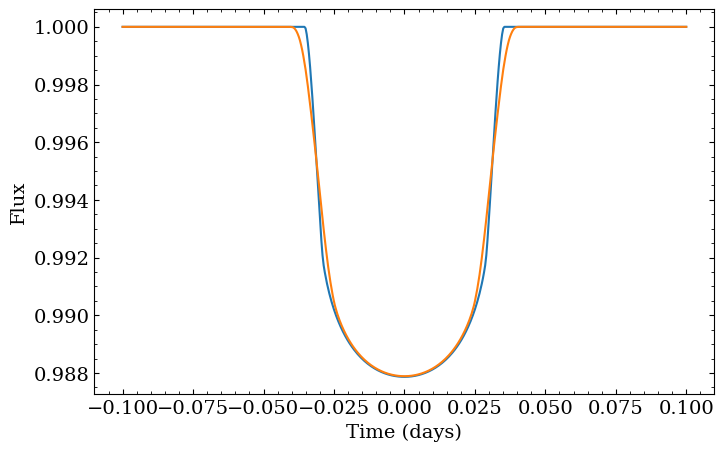

In [3]:
state["exposure_time"] = 1/24/60*15 # assume a 15 minute exposure time
state["oversample"] = 10
state["oversample_correction_order"] = 2

spherical_planet = OblateSystem(**state)
smeared_lc = spherical_planet.lightcurve()

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(spherical_planet.state["times"], spherical_lc, label="No smearing")
ax.plot(spherical_planet.state["times"], smeared_lc, label="With smearing")
ax.set(xlabel="Time (days)", ylabel="Flux");

For the remainder of the notebook though, let's not correct for exoposure time. Leaving it out will make differences in the visualizations easier to interpret.

Now let's squish the planet by an excessive amount. Compressing it will change the projected area, so we'll also inflate the equatorial radius to keep the area similar to what it was before. Why only correct for the `f1` squish though, and not `f2`? The latter compresses the planet along the "y" axis of the coordinate system centered on the planet and aligned with its orbital plane. In this configuration where the inclination is 90 degrees, that corresponds to the line of sight, so any compression in that direction does not change the projected area.

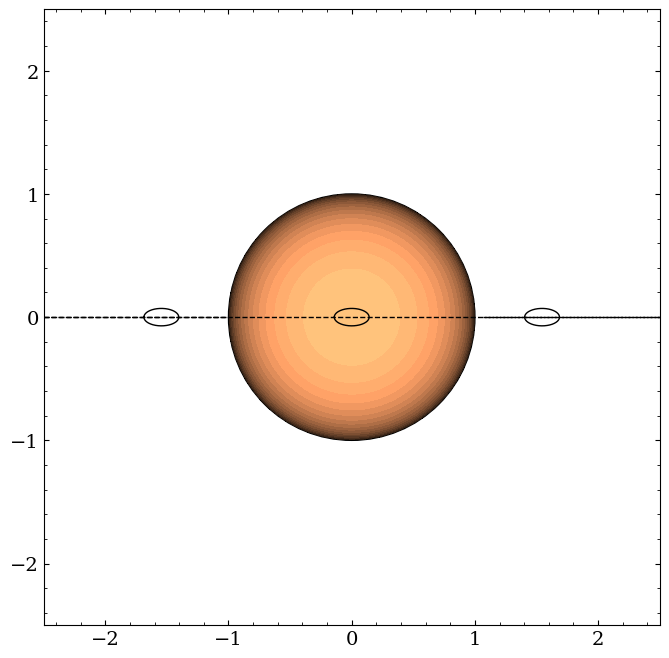

In [4]:
state["oversample"] = 1
state["f1"] = 0.5
state["f2"] = 0.5
state["r"] = state["r"] / jnp.sqrt(1 - state["f1"])
triaxial_planet = OblateSystem(**state)

triaxial_planet.illustrate(times=jnp.array([-0.05, 0.0, 0.05]), window_size=5.0)

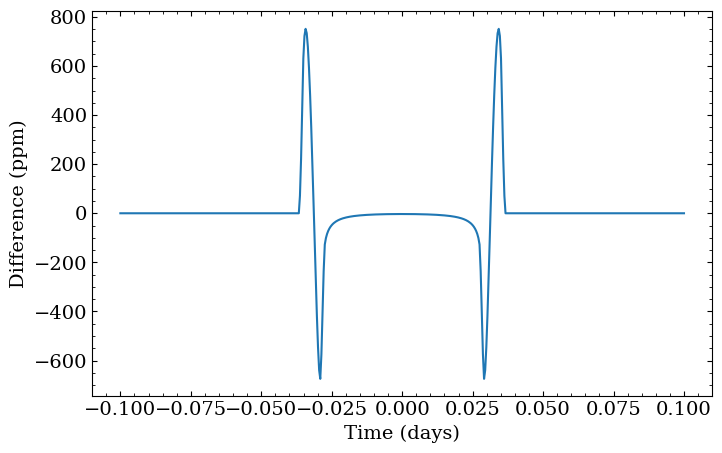

In [5]:
oblate_lc = triaxial_planet.lightcurve()

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(triaxial_planet.state["times"], (spherical_lc - oblate_lc)*1e6)
ax.set(xlabel="Time (days)", ylabel="Difference (ppm)");

Note how the only noticable differences are during ingress and egress here, and that the difference curve is symmetric. There are a few reasons for this:

First, this planet is not tidally locked, meaning it just drifts along its orbit without ever changing its projected area. It wobbles a bit because of numerical effects, but we can confirm that it's pretty much constant:

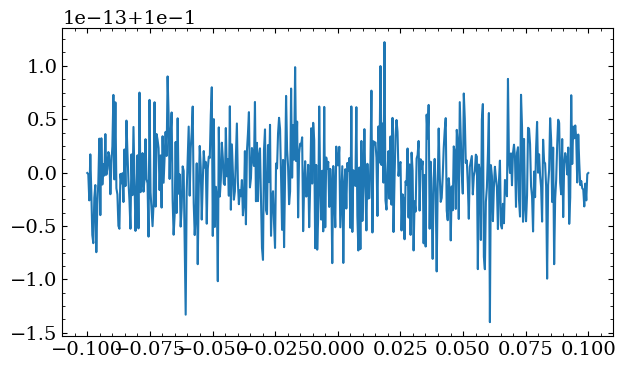

In [6]:
fig, ax = plt.subplots()
ax.plot(triaxial_planet.state["times"], triaxial_planet.state["effective_projected_r"])

Let's force the same hemisphere to always face the star, which will force the projected area to change:

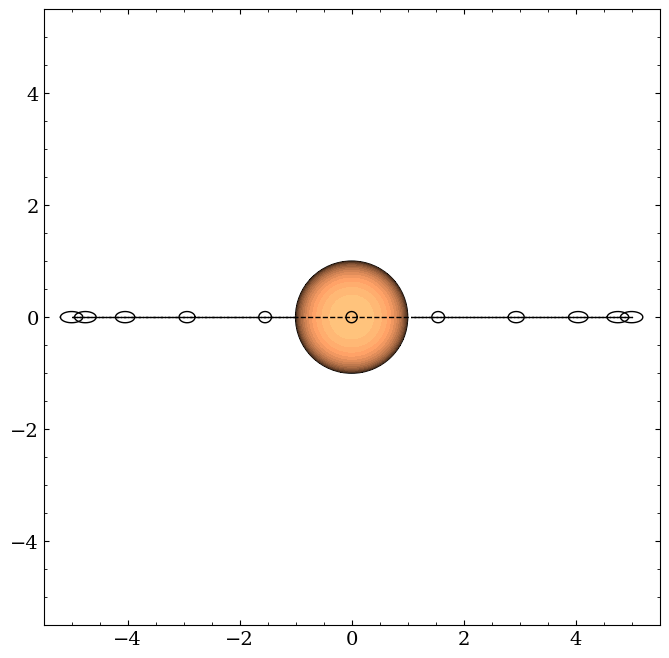

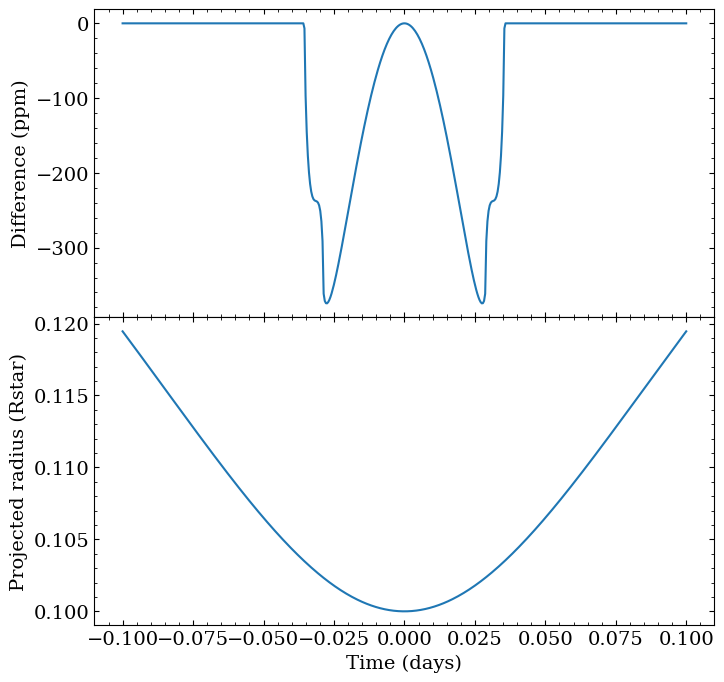

In [7]:
state["tidally_locked"] = True
state["r"] = 0.1 / jnp.sqrt(1 - state["f1"]) / jnp.sqrt(1 - state["f2"])
locked_planet = OblateSystem(**state)
locked_lc = locked_planet.lightcurve()

locked_planet.illustrate(times=jnp.linspace(-0.25, 0.25, 11), window_size=11.0)

fig, ax = plt.subplots(figsize=(8,8), nrows=2, sharex=True)
ax[0].plot(locked_planet.state["times"], (locked_lc-spherical_lc)*1e6)
ax[1].plot(locked_planet.state["times"], locked_planet.state["effective_projected_r"])
ax[0].set(ylabel="Difference (ppm)")
ax[1].set(xlabel="Time (days)", ylabel="Projected radius (Rstar)");
fig.subplots_adjust(hspace=0);

Now there's more curvature to the difference within the transit itself caused by the changing projected area. Notice also though that this dramatically shrunk the amplitude of the difference, since now that the planet is always facing the star, its projected outline is actually pretty close to circular around the time of transit. Since we've picked equal compressions in both directions, at the mid transit time, it's actually *identical* to the original planet.

To break the symmetry, let's unlock the planet, put in on a slightly less inclined orbit, and give it some obliquity/precession:

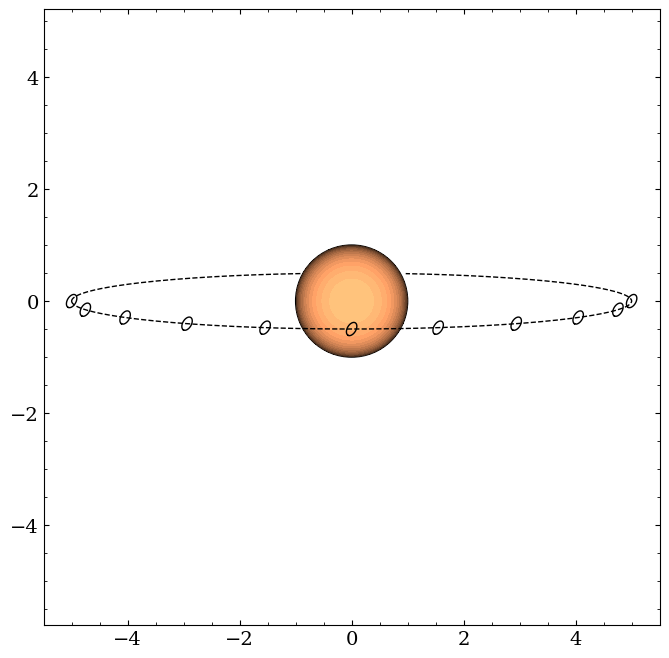

In [8]:
state = {
    "t_peri" : -0.25,
    "times" : jnp.linspace(-0.1, 0.1, 500),
    "a" : 5.0,
    "period" : 1.0,
    "r" : 0.1,
    "i" : jnp.pi/2 - 0.1,
    "ld_u_coeffs":jnp.array([0.4, 0.26]),
    "f1" : 0.5,
    "obliq" : jnp.pi/3,
    "prec" : 0.4,
    "tidally_locked" : False,
}

rolled_planet = OblateSystem(**state)
eff = rolled_planet.state["effective_projected_r"][0]
state["r"] *= 0.1/eff
rolled_planet = OblateSystem(**state)

rolled_planet.illustrate(times=jnp.linspace(-0.25, 0.25, 11), window_size=11.0)

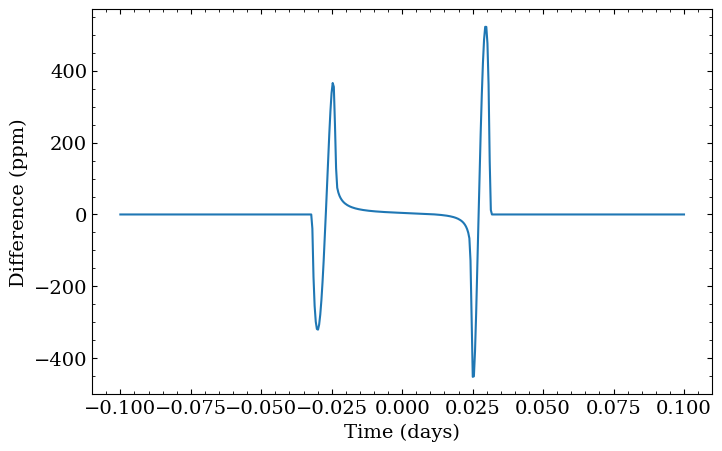

In [9]:
rolled_lc = rolled_planet.lightcurve()

# need to also regenerate the spherical planet since we're now crossing over a different
# part of the star with different limb darkening

state = {
    "t_peri" : -0.25,
    "times" : jnp.linspace(-0.1, 0.1, 500),
    "a" : 5.0,
    "period" : 1.0,
    "r" : 0.1,
    "i" : jnp.pi/2 - 0.1,
    "ld_u_coeffs":jnp.array([0.4, 0.26]),
    "f1" : 0.0,
}
spherical_planet = OblateSystem(**state)
spherical_lc = spherical_planet.lightcurve()

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(rolled_planet.state["times"], (rolled_lc-spherical_lc)*1e6)
ax.set(xlabel="Time (days)", ylabel="Difference (ppm)");

This illustrates just how flexible models of non-spherical planets can be--- depending on the flattening, planet orientation, and orbital orientations, you can end up with potentially asymmetric deviations at ingress and egress, and also area-driven changes even during full transit.

That last model was kind of overkill, though. By not forcing the planet to be tidally locked, its orientation never changes, so there are actually an infinite number of parameter combinations that can give the same lightcurve. So, when actually fitting data of planets that we don't think are tidally locked, we're better off abandoning the full 3D model and just parameterizing the planet based on its projected shape. We can do this in ``squishyplanet`` by setting ``parameterize_with_projected_ellipse`` to ``True`` and by providing the appropriate ``projected_r``, ``projected_f``, and ``projected_theta`` parameters.

For example, the following two parameterizations are equivalent:

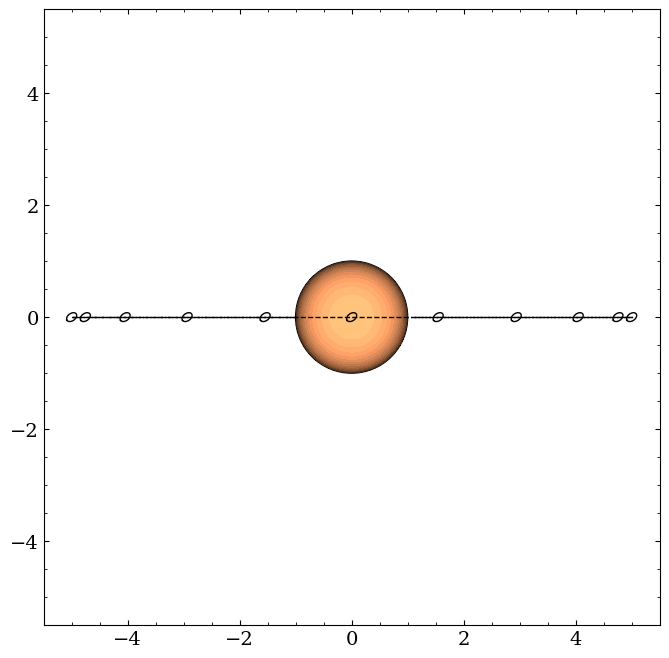

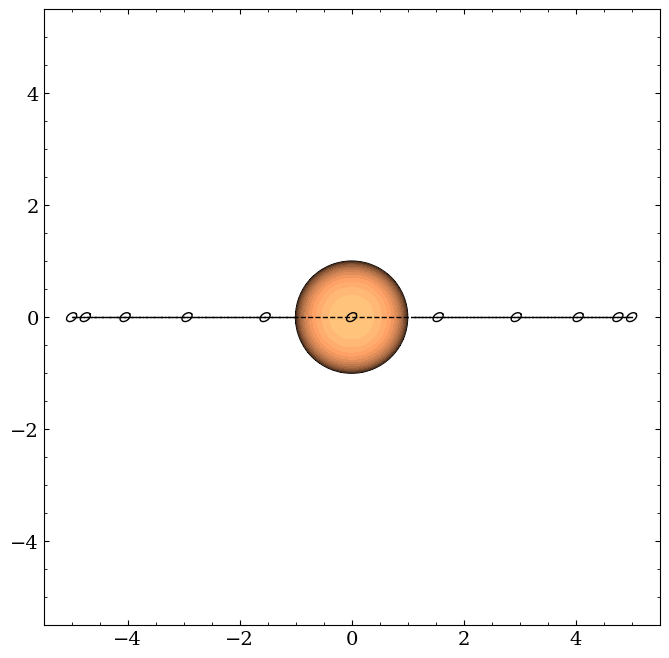

In [10]:
state = {
    "t_peri" : -0.25,
    "times" : jnp.linspace(-0.1, 0.1, 500),
    "a" : 5.0,
    "period" : 1.0,
    "r" : 0.1,
    "i" : jnp.pi/2,
    "ld_u_coeffs":jnp.array([0.4, 0.26]),
    "tidally_locked" : False,
    "f1" : 0.5,
    "obliq" : jnp.pi/4,
    "prec" : jnp.pi/4,
}

planet1 = OblateSystem(**state)
area = planet1.state["effective_projected_r"][0]**2 * jnp.pi
planet1.illustrate(times=jnp.linspace(-0.25, 0.25, 11), window_size=11.0)


from squishyplanet.engine.parametric_ellipse import poly_to_parametric_helper
d = {}
for key in planet1._coeffs_2d.keys():
    d[key] = planet1._coeffs_2d[key][0]
_, _, _, _, cosa, sina = poly_to_parametric_helper(**d)
rot_ang = (jnp.arctan(sina / cosa))[0]
    
state = {
    "parameterize_with_projected_ellipse" : True,
    "projected_r" : 0.1,
    "projected_f" : (-area + (jnp.pi * 0.1**2)) / ((jnp.pi * 0.1**2)),
    "projected_theta" : rot_ang,
    "t_peri" : -0.25,
    "times" : jnp.linspace(-0.1, 0.1, 500),
    "a" : 5.0,
    "period" : 1.0,
    "i" : jnp.pi/2,
    "ld_u_coeffs":jnp.array([0.4, 0.26]),
    "tidally_locked" : False,
}
planet2 = OblateSystem(**state)
planet2.illustrate(times=jnp.linspace(-0.25, 0.25, 11), star_centered=True, window_size=11.0)

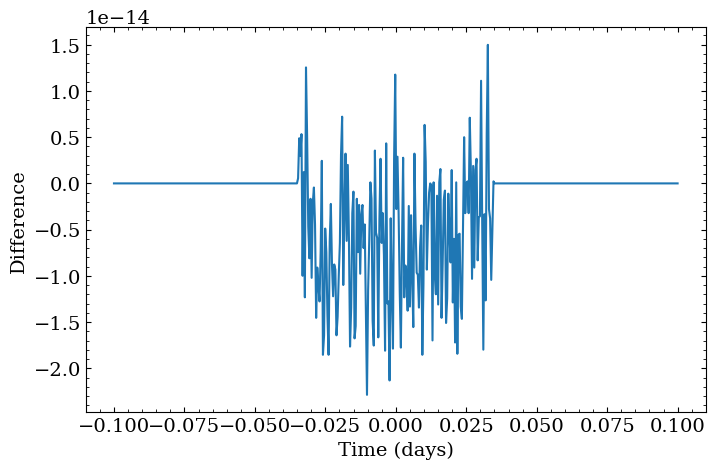

In [11]:
lc1 = planet1.lightcurve()
lc2 = planet2.lightcurve()

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(planet1.state["times"], (lc1-lc2))
ax.set(xlabel="Time (days)", ylabel="Difference");

These are effectively equivalent up to small numerical artifacts. So, when computing only a transit lightcurve of a planet that should not change its projected orientation on the timescale of your observations, you should go with the simpler 2D parameterization.

Last, we'll note that throughout the notebook we've been using a quadratic limb darkening law for the star. For any of these deformed geometries though, ``squishyplanet`` can also handle arbitrary order limb darkening perscriptions. Doing this involves just adding coefficients to the ``ld_u_coeffs`` input parameter. However, it's up to the user to make sure these coefficients are physically reasonable.

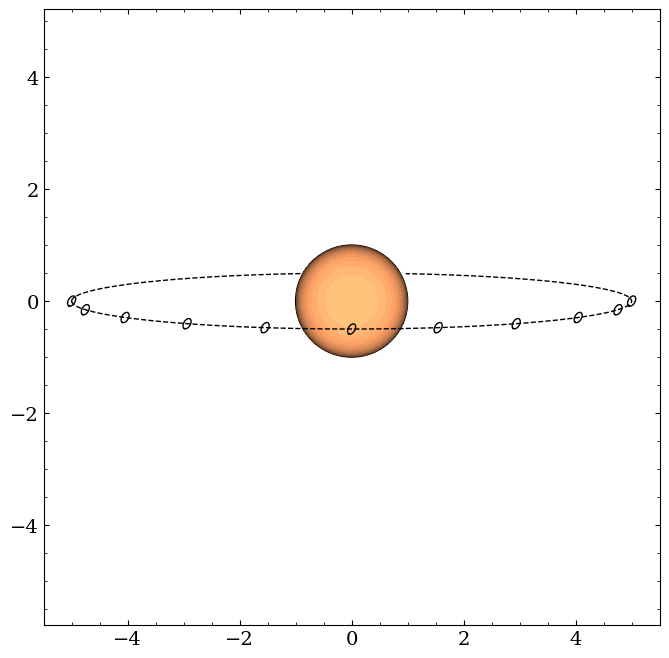

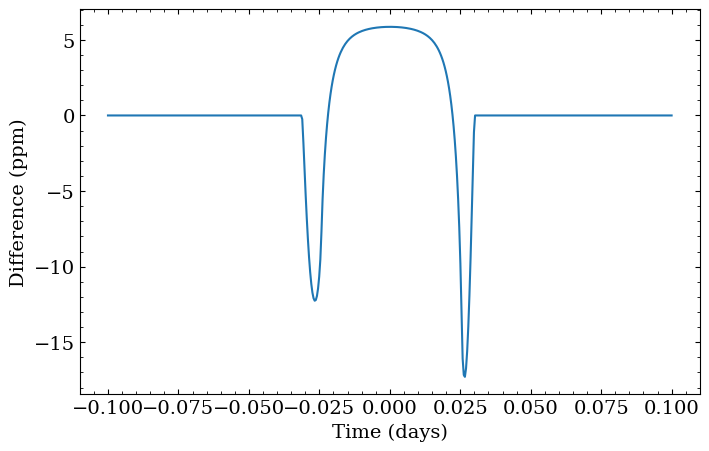

In [12]:
state = {
    "t_peri" : -0.25,
    "times" : jnp.linspace(-0.1, 0.1, 500),
    "a" : 5.0,
    "period" : 1.0,
    "r" : 0.1,
    "i" : jnp.pi/2 - 0.1,
    "ld_u_coeffs":jnp.array([0.4, 0.26, 0.1, 0.2]),
    "f1" : 0.5,
    "obliq" : jnp.pi/3,
    "prec" : 0.4,
    "tidally_locked" : False,
}

quartic_ld_planet = OblateSystem(**state)
quartic_ld_planet.illustrate(times=jnp.linspace(-0.25, 0.25, 11), window_size=11.0)

lc1 = quartic_ld_planet.lightcurve()
lc2 = quartic_ld_planet.lightcurve({"ld_u_coeffs":jnp.array([0.4, 0.26, 0.1, 0.21])})

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(quartic_ld_planet.state["times"], (lc1-lc2)*1e6)
ax.set(xlabel="Time (days)", ylabel="Difference (ppm)");

This last example also illustrates the preferred way to vary parameters for a given system. Instead of creating new ``OblateSystems`` for each set of parameters, you can just pass new parameters to the ``lightcurve`` method. This will be much faster, since the system only needs to be initialized once and JAX will not need to re-trace the model for subsequent calls. The same holds for the ``loglike`` method.